# Calculate pairwise distances between a contour and grid cells

In this notebook, we will demonstrate how to calculate the distance from every grid cell to the nearest grid cell along a contour. We will demonstrate this by computing the distance from each grid cell in a data array to the sea ice edge. We will use monthly sea ice concentration from ACCESS-OM2-01 over the Southern Ocean to perform these calculations.  
  
*Useful definitions*  
**Nearest neighbour**: Refers to the search of the point within a predetermined set of points that is located closest (spatially) to a given point. In order words, what grid cell along the sea ice edge is closest to a grid cell with coordinates `i`, `j`.  
**Sea ice edge**: Refers to the northernmost grid cell where sea ice concentration is $10\%$ or above.

## Loading modules

In [1]:
import intake

import xarray as xr
import numpy as np
import datetime as dt

from sklearn.neighbors import BallTree
import matplotlib.pyplot as plt

## Creating a session in the COSIMA cookbook

In [2]:
from dask.distributed import Client
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 48,Total memory: 188.56 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45827,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 48
Started: Just now,Total memory: 188.56 GiB
Comm: tcp://127.0.0.1:34301,Total threads: 6
Dashboard: /proxy/38597/status,Memory: 23.57 GiB
Nanny: tcp://127.0.0.1:46039,


## Accessing ACCESS-OM2-01 data

First we load the ACCESS-NRI default intake catalog.

In [3]:
catalog = intake.cat.access_nri

We use monthly sea ice outputs. Here, we load only two months of sea ice data.

In [4]:
cat_subset = catalog['01deg_jra55v140_iaf_cycle4']
ds = cat_subset.search(variable='aice_m',
).to_dask(
    xarray_combine_by_coords_kwargs=dict(compat="override",
                                         data_vars="minimal",
                                         coords="minimal")
)

var_ice = ds['aice_m']
var_ice = var_ice.sel(time=slice('1978-01', '1978-03'))
var_ice

<xarray.DataArray 'aice_m' (time: 3, nj: 2700, ni: 3600)> Size: 117MB
dask.array<getitem, shape=(3, 2700, 3600), dtype=float32, chunksize=(1, 270, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 24B 1978-01-01 1978-02-01 1978-03-01
    TLON     (nj, ni) float32 39MB dask.array<chunksize=(270, 360), meta=np.ndarray>
    TLAT     (nj, ni) float32 39MB dask.array<chunksize=(270, 360), meta=np.ndarray>
    ULON     (nj, ni) float32 39MB dask.array<chunksize=(270, 360), meta=np.ndarray>
    ULAT     (nj, ni) float32 39MB dask.array<chunksize=(270, 360), meta=np.ndarray>
Dimensions without coordinates: nj, ni
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

The sea ice outputs need some processing before we can start our calculations. You can check this [example](Sea_Ice_Coordinates.ipynb) for a guide on how to load and plot sea ice data.  
  
We will follow these processing steps:
1. Correct time dimension values by subtracting 12 hours,
2. Attach the ocean model grid so we can calculate distances.

In [5]:
# Loading area_t to get ocean grid
var_search = catalog['01deg_jra55v140_iaf_cycle4'].search(variable='area_t')
var_search = var_search.search(path=var_search.df['path'][0])
ds = var_search.to_dask()
area_t = ds['area_t']

# Apply time correction so data appears in the middle (12:00) of the day rather than at the beginning of the day (00:00)
var_ice['time'] = var_ice.time.to_pandas() - dt.timedelta(hours = 12)

# Change coordinates so they match ocean dimensions 
var_ice.coords['ni'] = area_t['xt_ocean'].values
var_ice.coords['nj'] = area_t['yt_ocean'].values

# Rename coordinate variables so they match ocean data
var_ice = var_ice.rename(({'ni': 'xt_ocean', 'nj': 'yt_ocean'}))

# Subsetting data for the Southern Ocean
var_ice = var_ice.sel(yt_ocean = slice(-80, -45))
var_ice

<xarray.DataArray 'aice_m' (time: 3, yt_ocean: 713, xt_ocean: 3600)> Size: 31MB
dask.array<getitem, shape=(3, 713, 3600), dtype=float32, chunksize=(1, 270, 360), chunktype=numpy.ndarray>
Coordinates:
    TLON      (yt_ocean, xt_ocean) float32 10MB dask.array<chunksize=(243, 360), meta=np.ndarray>
    TLAT      (yt_ocean, xt_ocean) float32 10MB dask.array<chunksize=(243, 360), meta=np.ndarray>
    ULON      (yt_ocean, xt_ocean) float32 10MB dask.array<chunksize=(243, 360), meta=np.ndarray>
    ULAT      (yt_ocean, xt_ocean) float32 10MB dask.array<chunksize=(243, 360), meta=np.ndarray>
  * time      (time) datetime64[ns] 24B 1977-12-31T12:00:00 ... 1978-02-28T12...
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 6kB -79.97 -79.93 -79.88 ... -45.11 -45.04
Attributes:
    units:          1
    long_name:      ice area  (aggregate)
    cell_measures:  area: tarea
    cell_methods:   time: mean
    time_rep:       averaged

## Finding sea ice edge
The sea ice edge is the defined as the northernmost areas where sea ice concentration (SIC) is over $10\%$. This is a multistep process:

1. Identify cells where $\text{SIC} >= 0.1$, classifying them with a value of 1;
2. Calculate the cumulative sum along latitude;
3. Apply mask to constrain to only cells with $\text{SIC} >= 0.1$;
4. Choose the maximum for each longitude.

We'll demonstrate this process over the first timestep of data.

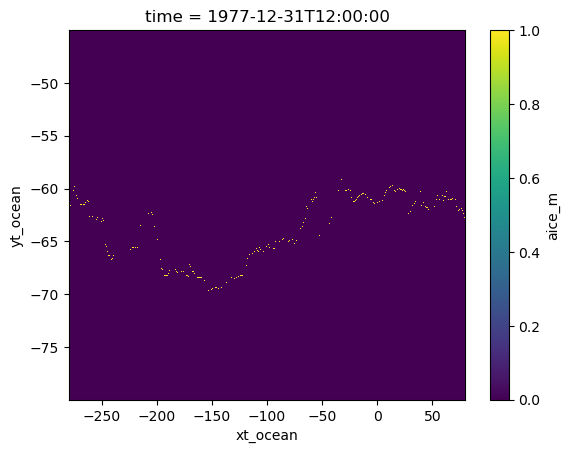

In [6]:
is_ice = var_ice.isel(time=0) >= 0.1
cumulative_ice = is_ice.cumsum(dim='yt_ocean')
ice_edge = (cumulative_ice == cumulative_ice.max('yt_ocean')) * is_ice

ice_edge.plot()

### Checking results in relation to SIC data

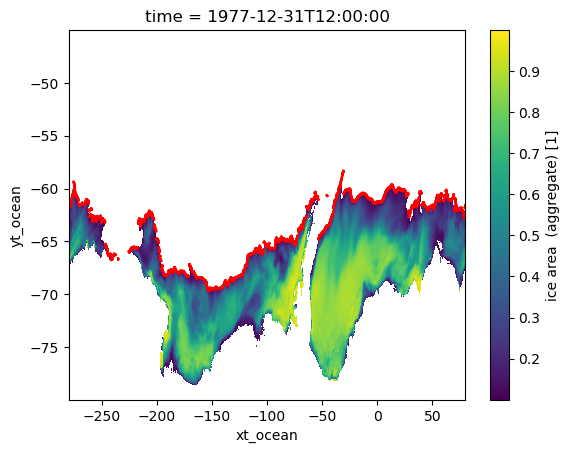

In [7]:
var_ice.where(var_ice >= 0.1).isel(time=0).plot()
ice_edge.plot.contour(colors=["red"])

Above we plotted only cells with SIC greater or equal to 0.1. The red line represents the sea ice edge we identified in the previous step. We can be satisfied that we identified the sea ice edge correctly.

## Getting coordinate pairs for our entire grid
We will use the latitude and longitude values in our data to create coordinate pairs. We only need to get this information once if we are calculating distances from the same grid.  

In [8]:
grid_x, grid_y = np.meshgrid(
    var_ice.xt_ocean.values,
    var_ice.yt_ocean.values,
)

# Changing shape so there are two values per row
grid_coords = np.vstack([grid_y.flat, grid_x.flat]).T
grid_coords

array([[ -79.96816911, -279.95      ],
       [ -79.96816911, -279.85      ],
       [ -79.96816911, -279.75      ],
       ...,
       [ -45.03607147,   79.75      ],
       [ -45.03607147,   79.85      ],
       [ -45.03607147,   79.95      ]])

## Getting coordinate pairs for sea ice edge
We will find the index for the sea ice edge so we can identify the latitude at which the sea ice edge occurs. This will be combined with all longitude values to create the coordinate pairs for the sea ice edge.  
  
Note that this step has to be done once for every time step as the sea ice edge changes over time.

In [9]:
# Getting the indices for cell with maximum value along yt_ocean dimension
ice_yt = ice_edge.yt_ocean[ice_edge.argmax(dim='yt_ocean')]
ice_coords = np.vstack([ice_yt, ice_edge.xt_ocean]).T
ice_coords

array([[ -61.84325357, -279.95      ],
       [ -61.84325357, -279.85      ],
       [ -61.84325357, -279.75      ],
       ...,
       [ -61.60640174,   79.75      ],
       [ -61.65391774,   79.85      ],
       [ -61.84325357,   79.95      ]])

## Using Nearest Neighbours algorithm to calculate distance to closest sea ice edge cell

We will build a data structure called [BallTree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree) for our calculations, from the points comprising the sea ice edge. This structure allows us to efficiently query the nearest point within the sea ice edge set to any arbitrary point, according to some kind of metric. Because we're on a sphere, we use the [haversine (great circle) distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html), which also requires that we transform coordinates from degrees to radians. `scikit-learn` also offers a [KDTree](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html) for a similar purpose, but this doesn't support the haversine distance as a metric, so we opt for the ball tree instead.

The advantage of using a data structure like a ball tree is that we trade off slightly more time and memory to construct the tree for more efficient querying. This makes it feasible to query the closest sea ice edge cell to every point on the grid, which may otherwise have excessive time and/or memory requirements for a brute force approach.

In [10]:
%%time

# First we set up our Ball Tree. Coordinates must be given in radians.
ball_tree = BallTree(np.deg2rad(ice_coords), metric='haversine')

CPU times: user 5.68 ms, sys: 0 ns, total: 5.68 ms
Wall time: 5.34 ms


In [11]:
%%time

# The nearest neighbour calculation will give two outputs: distances and indices
# We only need the distances for now, so ignore the second output
distances_radians, _ = ball_tree.query(np.deg2rad(grid_coords), return_distance=True)

CPU times: user 22.8 s, sys: 342 ms, total: 23.2 s
Wall time: 20.1 s


## Transforming distance from radians to kilometers

Because the haversine distance operates in terms of radians only, we will need to multiply by the resulting distances by Earth's radius to get distances in radians. We will also reshape the results so it matches our original grid.

In [12]:
distances_km = distances_radians * 6371

distances_t0 = xr.DataArray(
    data=distances_km.reshape(var_ice.yt_ocean.size, -1),
    dims=['yt_ocean', 'xt_ocean'],
    coords={'yt_ocean': var_ice.yt_ocean, 'xt_ocean': var_ice.xt_ocean}
)

distances_t0

<xarray.DataArray (yt_ocean: 713, xt_ocean: 3600)> Size: 21MB
array([[ 805.00144028,  803.19226827,  801.38249999, ...,  810.42536522,
         808.61799012,  806.81001469],
       [ 806.69292563,  804.88000362,  803.06648432, ...,  812.12809432,
         810.31697234,  808.50524899],
       [ 808.40803346,  806.59143086,  804.77423025, ...,  813.85423949,
         812.03943914,  810.22403667],
       ...,
       [1607.76336769, 1606.55053756, 1605.36467069, ..., 1611.56299844,
        1610.26966326, 1609.00309777],
       [1615.51041181, 1614.30178279, 1613.12003095, ..., 1619.29692977,
        1618.0080497 , 1616.74585538],
       [1623.26793377, 1622.06347241, 1620.88580274, ..., 1627.04144284,
        1625.75698268, 1624.4991249 ]])
Coordinates:
  * yt_ocean  (yt_ocean) float64 6kB -79.97 -79.93 -79.88 ... -45.11 -45.04
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95

## Turning results into data array
We will also apply a mask to our results, so we will only keep values for cells where SIC was greater or equal to 0.1.

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 19.61 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


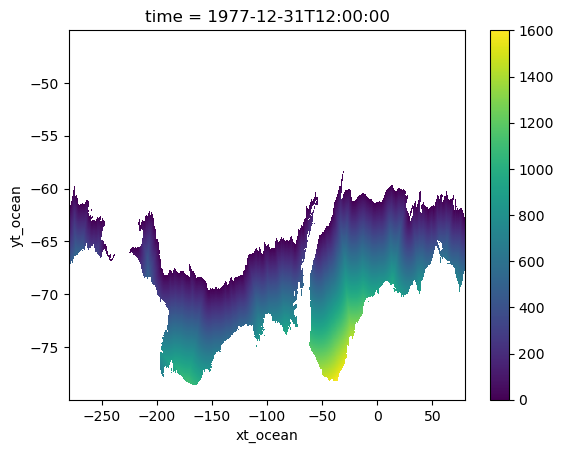

In [13]:
distances_t0.where(is_ice).plot()

## Calculating results for other time steps

We can wrap this up into a function to calculate distances for a given timestep. This function returns the ice mask as a second value, so that we can make the plots in the same format as demonstrated so far.

In [14]:
def ice_edge_distances(ice_ds):
    x, y = np.meshgrid(np.deg2rad(var_ice.xt_ocean.values),
                   np.deg2rad(var_ice.yt_ocean.values))
    grid_coords = np.vstack([y.flat, x.flat]).T
    
    is_ice = ice_ds >= 0.1
    cumulative_ice = is_ice.cumsum(dim='yt_ocean')
    ice_edge = (cumulative_ice == cumulative_ice.max('yt_ocean')) * is_ice
    
    ice_yt = ice_edge.yt_ocean[ice_edge.argmax(dim='yt_ocean')]
    ice_coords = np.vstack([ice_yt, ice_edge.xt_ocean]).T
    
    ball_tree = BallTree(np.deg2rad(ice_coords), metric='haversine')
    distances_radians, _ = ball_tree.query(grid_coords, return_distance=True)
    
    distances_km = distances_radians * 6371
    distances = xr.DataArray(
        data=distances_km.reshape(ice_ds.yt_ocean.size, -1),
        dims=['yt_ocean', 'xt_ocean'],
        coords={'yt_ocean': ice_ds.yt_ocean, 'xt_ocean': ice_ds.xt_ocean},
        name='ice_edge_distance'
    )
    
    return distances, is_ice

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 19.61 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


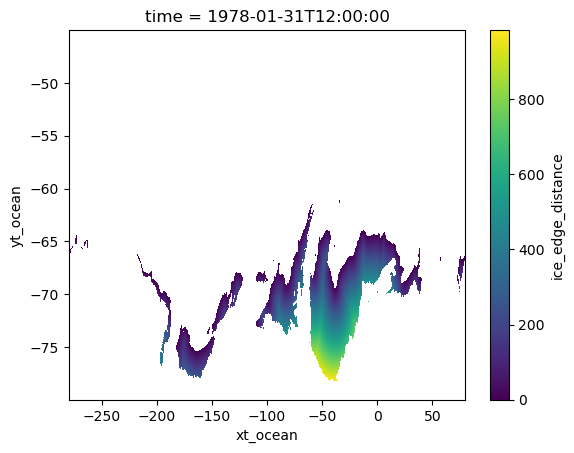

In [15]:
distances_t1, mask = ice_edge_distances(var_ice.isel(time=1))

distances_t1.where(mask).plot()

## Stacking results into one data array

In [16]:
dist_ice = xr.concat([distances_t0.where(is_ice), distances_t1.where(mask)], dim='time')
dist_ice

<xarray.DataArray (time: 2, yt_ocean: 713, xt_ocean: 3600)> Size: 41MB
dask.array<concatenate, shape=(2, 713, 3600), dtype=float64, chunksize=(1, 270, 360), chunktype=numpy.ndarray>
Coordinates:
  * yt_ocean  (yt_ocean) float64 6kB -79.97 -79.93 -79.88 ... -45.11 -45.04
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
    TLON      (yt_ocean, xt_ocean) float32 10MB dask.array<chunksize=(243, 360), meta=np.ndarray>
    TLAT      (yt_ocean, xt_ocean) float32 10MB dask.array<chunksize=(243, 360), meta=np.ndarray>
    ULON      (yt_ocean, xt_ocean) float32 10MB dask.array<chunksize=(243, 360), meta=np.ndarray>
    ULAT      (yt_ocean, xt_ocean) float32 10MB dask.array<chunksize=(243, 360), meta=np.ndarray>
  * time      (time) datetime64[ns] 16B 1977-12-31T12:00:00 1978-01-31T12:00:00

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/distributed/client.py:3362: UserWarning: Sending large graph of size 39.21 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


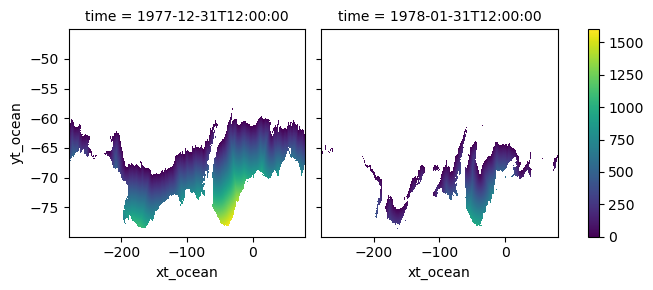

In [17]:
dist_ice.plot(col='time')

We are done! We should be able to follow the same workflow to calculate distances to any line/point of your interest.

In [18]:
client.close()